In [2]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import siconos as sn

In [49]:
class spectral_method:
    def __init__(self, depth, layers, segments = 1):

        self.n = layers
        self.x = self.JacobiGL(0, 0, layers-1)

        D_calc = lambda n: np.matmul(np.transpose(self.vandermonde_dx()),
                                                   np.linalg.inv(np.transpose(self.vandermonde_calculator())))*(depth/2)

        self.D = D_calc(layers)
        M_calc = lambda n: np.dot(np.linalg.inv(self.vandermonde_calculator()),
                                       np.linalg.inv(np.transpose(self.vandermonde_calculator())))*(depth/2)

        self.M = M_calc(layers)
        self.x = ((self.x+1)/2) * depth
        self.segments = segments

        if segments>1:
            M_T = np.zeros((layers*segments, layers*segments))
            D_T = np.zeros((layers*segments, layers*segments))
            x_T = np.zeros(layers*segments)
            s_x = depth/segments
            x_n = np.copy(self.x)/segments

            for k in range(segments):
                M_T[k*layers:(k+1)*layers, k*layers:(k+1)*layers] = self.M/segments
                D_T[k*layers:(k+1)*layers, k*layers:(k+1)*layers] = self.D/segments
                x_T[k*layers:(k+1)*layers] = x_n + k*s_x
            
            self.D = D_T
            self.M = M_T
            self.x = x_T

    def JacobiGL(self, a, b, n):
        alpha = a + 1
        beta = b + 1
        N = n - 2
        if N == 0:
            x = np.array([(alpha - beta) / (alpha + beta + 2)])
            w = 2
        else:
            h1 = 2 * np.arange(0, N + 1) + alpha + beta
            J1 = np.diag(-1 / 2 * (alpha ** 2 - beta ** 2) / (h1 + 2) / h1)
            J2 = np.diag(2 / (h1[0:N] + 2) * np.sqrt(np.arange(1, N + 1) * (np.arange(1, N + 1) + alpha + beta) *
                                                     (np.arange(1, N + 1) + alpha) * (np.arange(1, N + 1) + beta) * (
                                                                 1 / (h1[0:N] + 1)) * (1 / (h1[0:N] + 3))), 1)
            J = J1 + J2
            J = J + J.T
            x, w = np.linalg.eig(J)
            
        return np.array([-1, *np.sort(x), 1])

    def JacobiP(self, x, alpha, beta, n):
        P_n = np.zeros((n, x.shape[0]))
        P_n[0] = 1
        P_n[1] = 0.5 * (alpha - beta + (alpha + beta + 2) * x)
        for i in range(1, n - 1):
            an1n = 2 * (i + alpha) * (i + beta) / ((2 * i + alpha + beta + 1) * (2 * i + alpha + beta))
            ann = (alpha ** 2 - beta ** 2) / ((2 * i + alpha + beta + 2) * (2 * i + alpha + beta))
            anp1n = 2 * (i + 1) * (i + alpha + beta + 1) / ((2 * i + alpha + beta + 2) * (2 * i + alpha + beta + 1))

            P_n[i + 1] = ((ann + x) * P_n[i] - an1n * P_n[i - 1]) / anp1n

        return P_n


    def JacobiP_n(self, x, alpha, beta, n):
        P_n = self.JacobiP(x, alpha, beta, n)
        if alpha == 1 and beta == 1:
            gamma = lambda alpha, beta, m: 2 ** (3) * (m + 1) / (m + 2) * 1 / ((2 * m + alpha + beta + 1))
        elif alpha == 0 and beta == 0:
            gamma = lambda alpha, beta, m: 2 / ((2 * m + alpha + beta + 1))
        elif alpha == -1 / 2 and beta == - 1 / 2:
            gamma = lambda alpha, beta, m: 2 * scp.math.factorial(m) / ((2 * m + alpha + beta + 1) * scp.gamma(m + 1 / 2))

        for i in range(n):
            d = np.sqrt(gamma(alpha, beta, i))
            P_n[i] = P_n[i] / d

        return P_n


    def GradJacobi_n(self, x, alpha, beta, n):
        P_diff = np.zeros((n, x.shape[0]))
        JacobiPnorma = self.JacobiP_n(x, alpha + 1, beta + 1, n)
        for i in range(1, n):
            P_diff[i] = JacobiPnorma[i - 1] * np.sqrt(i * (i + alpha + beta + 1))
        return P_diff



    def vandermonde_calculator(self):
        n = self.n
        x = self.x
        return (self.JacobiP_n(x, 0, 0, n))


    def vandermonde_dx(self):
        n = self.n
        x = self.x
        return (self.GradJacobi_n(x, 0, 0, n))

    def expander(self, old_spectral, transform_vec):
        new_spectral = self
        
        length = old_spectral.x[-1]
        coeffs = np.linalg.inv(old.spectral.JacobiP_n(2*old_spectral.x/length - 1, 0, 0, old_spectral.n).T) @ transform_vec
        transformer = new_spectral.JacobiP_n(2*new_spectral.x/new_spectral.x[-1] - 1, 0, 0, old_spectral.n).T
        return transformer @ coeffs
   

    def projector(self, old_spec, big_vec):
        pass

    def interpolater(self, new_points, transform_vec):
        spectral = self
        length = spectral.x[-1]
        coeffs = np.linalg.inv(spectral.JacobiP_n(2*spectral.x/length - 1, 0, 0, spectral.n).T) @ transform_vec
        transformer = spectral.JacobiP_n(2*new_points/new_points[-1] - 1, 0, 0, spectral.n).T
        return transformer @ coeffs


In [3]:
class simple_method:
    def __init__(self, depth, total_points):

        tot_points = total_points
        
        self.x = np.linspace(0,depth,tot_points) 

        self.M = depth/(tot_points-1) * 0.5 * (np.identity(tot_points)+ np.diag(np.ones(tot_points -1), -1))

In [175]:
layers = 5
segments = 30
length = 30
tot_points = layers*segments

#Mx = spectral_method(length, layers, segments)

Mx = simple_method(length, tot_points)

res_conc = np.exp(-Mx.x)
beta = np.exp(-Mx.x**2)+0.001
mu1 = ca.SX.sym('mu', Mx.x.shape[0])
mu2 = ca.SX.sym('mu', Mx.x.shape[0])
lam = ca.SX.sym('lam', 2)
sigma = ca.SX.sym('sigma', Mx.x.shape[0])
sigma_p = ca.SX.sym('sigma_p', Mx.x.shape[0])
sigma_bar = ca.SX.sym('sigma_bar', Mx.x.shape[0])
inte = np.ones(tot_points).reshape(1,tot_points) 

gamma0 = 1
gamma1 = 1
gamma2 = 2
gamma3 = 1
gamma4 = 1
gamma5 = 0.5

df1 = (res_conc* gamma1/(gamma0*inte @ (Mx.M @ (sigma*res_conc)) + gamma1)**2-sigma_p*beta/(gamma2+gamma3*inte @ (Mx.M @ (sigma*beta*sigma_p)))) - lam[0]*np.ones(tot_points)
df2 = (gamma4*sigma*beta/(gamma3*inte @ (Mx.M @ (sigma*beta*sigma_p))+gamma4)**2) - lam[1]*np.ones(tot_points)

df = ca.vertcat(df1, df2)
g1 = df + ca.vertcat(mu1, mu2)
g2 = inte @ Mx.M @ sigma_p - 1
g3 = inte @ Mx.M @ sigma - 1
g = ca.vertcat(g1, g2, g3)

f = inte @ Mx.M @ (sigma*mu1) + inte @ Mx.M @ (sigma_p * mu2)

In [170]:
import time as time

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.82ms (153.05us) 800.79us ( 21.07us)        38
       nlp_g  |  19.36ms (509.37us)   2.63ms ( 69.18us)        38
  nlp_grad_f  |  10.10ms (259.10us)   1.41ms ( 36.21us)        39
   nlp_jac_g  | 768.90ms ( 19.72ms) 106.87ms (  2.74ms)        39
       total  |  16.56 s ( 16.56 s)   2.40 s (  2.40 s)         1
Solved 3.062230348587036


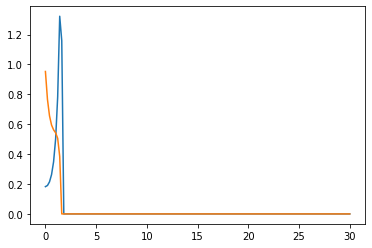

In [176]:
sigmas = ca.vertcat(sigma, sigma_p)
x = ca.vertcat(*[sigmas, mu1, mu2, lam])
lbg = np.zeros(2*(tot_points + 1))
ubg = np.zeros(2*(tot_points + 1))

s_opts = {'ipopt': {'print_level' : 1, 'linear_solver':'ma57', 'hessian_approximation':'limited-memory'} }#, 'tol':10**-3, 'acceptable_tol': 10**(-2)}}
prob = {'x': x, 'f': f, 'g': g}
lbx = ca.vertcat(*[np.zeros(x.size()[0] - 2), -ca.inf, -ca.inf])

t0 = time.time()
solver = ca.nlpsol('solver', 'ipopt', prob, s_opts)
sol = solver(lbx = lbx, lbg = lbg, ubg = ubg)
t1 = time.time()

print("Solved", t1-t0)
x_out = np.array(sol['x']).flatten()
#print(x_out)
plt.plot(Mx.x, x_out[0:tot_points])
plt.plot(Mx.x, x_out[tot_points:2*tot_points])